# TD4 - CNNs for Image Classification 
## Nicolas Dufour, Pascal Vanier, Vicky Kalogeiton

In this tutorial, we will see some classic architectures of convolutional networks and how to use pre-trained networks to speed-up training on new tasks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from matplotlib import pyplot as plt
from functools import partial
from tqdm import tqdm
import math
import numpy as np
import matplotlib.ticker as ticker
from torch.utils.data import DataLoader
import torchvision.models as models


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importance of weight initialization

The initialization of the weights of a Neural Network are a key aspect of the training of Neural Networks.



## Question 1
Using the FashionMNIST dataset, train a feed forward neural network with 2 hidden layers, with sizes 64 and 32. Use a cross-entropy loss.

Make sure to enable the initialization of the weights and biases with different methods. You will study the constante, kaiming, uniform, normal and xavier initializations (see `torch.nn.init`)

In [2]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.286, 0.353),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

class FFN(nn.Module):
    def __init__(self, input_size, output_size, init=nn.init.xavier_normal_):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        init(self.fc1.weight)
        self.fc2 = nn.Linear(64, 32)
        init(self.fc2.weight)
        self.fc3 = nn.Linear(32, output_size)
        init(self.fc3.weight)
        self.fc4 = nn.LogSoftmax(dim = 1)
    def forward(self,x): 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        return x






## Question 2
Plot the different training losses and compare the different initializations

Inits: 100%|██████████| 7/7 [00:52<00:00,  7.53s/it]


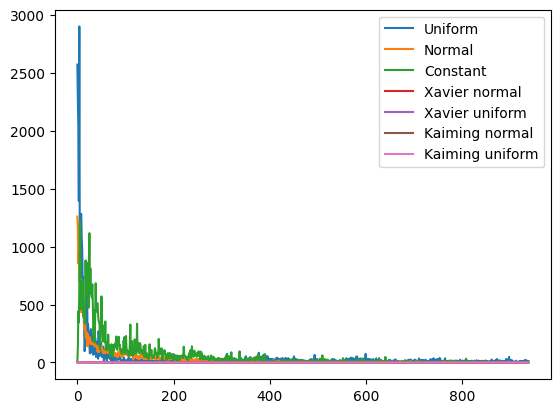

In [3]:

def train(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_losses.append(loss.detach().item())
            loss.backward()
            optimizer.step()
    return train_losses

def train_and_plot_all_inits(train_loader, criterion, device, inits, epochs=1, lr=3e-3):
    for init, init_name in tqdm(inits.items(), desc = "Inits"):
        model = FFN(784, 10, init=init).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        train_losses = train(model, train_loader, optimizer, criterion, device, epochs=epochs)
        plt.plot(train_losses, label=init_name)
    plt.legend()
    plt.show()
    


criterion = nn.CrossEntropyLoss()
inits = {
    torch.nn.init.uniform_: "Uniform",
    torch.nn.init.normal_: "Normal",
    partial(torch.nn.init.constant_, val = 1) : "Constant",
    torch.nn.init.xavier_normal_: "Xavier normal",
    torch.nn.init.xavier_uniform_: "Xavier uniform",
    torch.nn.init.kaiming_normal_: "Kaiming normal",
    torch.nn.init.kaiming_uniform_: "Kaiming uniform",    
} 
train_and_plot_all_inits(train_loader, criterion, device, inits)

# Regularization

When training a Neural Network, we want to avoid at all cost overfitting. Overfitting occures when when have overlearned on our training set. The first thing to do is to compare the performances (loss or metrics) of the train dataset with the validation dataset. If you see a gap in performances, this means that you have overfitted your network.

To study the impact of overfitting, we will leverage a synthetic dataset given by the following Dataset.

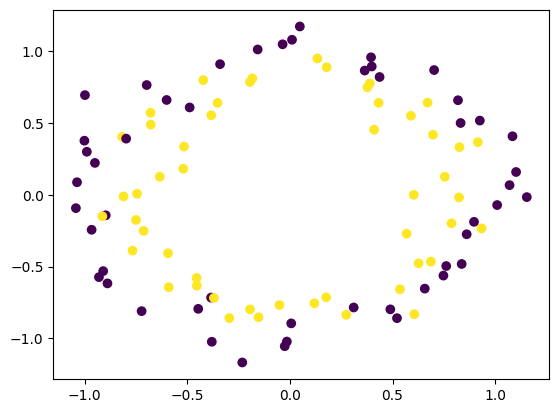

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

class CircleDataset(nn.Module):
    def __init__(self, num_samples, std=0.1, transform=None, seed=None):
        self.x, self.y = make_circles(n_samples=num_samples, noise=std, random_state=seed)
        self.x = torch.from_numpy(self.x).float()
        self.y = torch.from_numpy(self.y).float()
        self.len = self.x.shape[0]
        self.transform = transform
    
    
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.x[index]), self.y[index]
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
    
# Plot the dataset
dataset = CircleDataset(100)
plt.scatter(dataset.x[:,0], dataset.x[:,1], c=dataset.y)
plt.show()

### Question 3
Create a CircleDataset validation and test set with 500 samples, std=0.1. To be able to compare between experiments, use seed 3407 for the validation set and 3408 for the test set. This test set must be the same for every experiment we will do.

Note: Validation and test set are crucial to evaluate the performance of an ML algorithm. The goal is to be able to evaluate the generalisation abilities of our method. Indeed, if we overfit on the train set, we will have optimal performances but our method will not work in out of train set data. 

The validation set is used for both monitoring the evolution of training and to tune hyperparameters.

The test set must be used ONLY at the end of training/hparameters tuning. Otherwise, you risk overfitting on it.

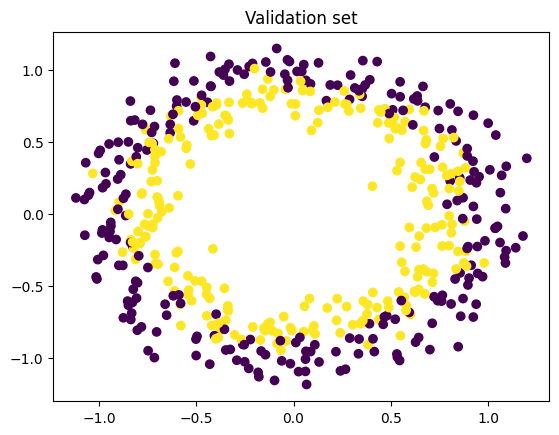

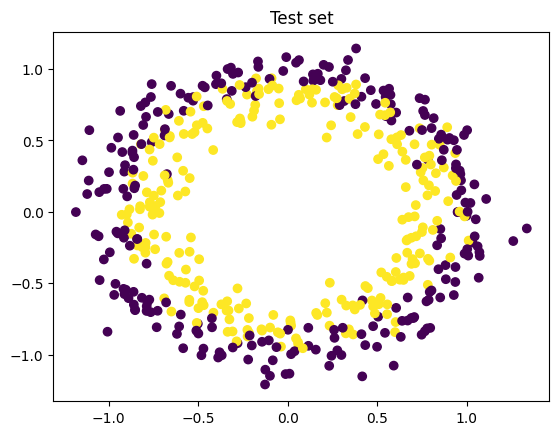

In [5]:
dataset_val = CircleDataset(500,std = 0.1,seed = 3407)
circle_val_loader = DataLoader(dataset_val, batch_size=64, shuffle=True)

dataset_test = CircleDataset(500,std = 0.1,seed = 3408)
circle_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

plt.scatter(dataset_val.x[:,0], dataset_val.x[:,1], c=dataset_val.y)
plt.title("Validation set")
plt.show()

plt.scatter(dataset_test.x[:,0], dataset_test.x[:,1], c=dataset_test.y)
plt.title("Test set")
plt.show()


### Question 4
Create a Feed Forward architecture with 2 hidden layers of size 500, 500. Use the `BCELoss`, and the Adam optimizer with lr=5e-3. Train for 50000 steps ploting the loss and the accuracy for both the train and val set after each epoch end. Also, compute the accuracy at the end of training on the test set. Train on a new Circle dataset having 50 data points. What can you say about the result?

In [6]:
def success_rate(model, data_loader, device):
    model.eval() 
    success = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            for x,y in zip(data,target):
                output = model(x)
                pred = 0 if output<0.5 else 1
                if y == pred:
                    success += 1
    return success / len(data_loader.dataset)


Epochs training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epochs training: 100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.486, 0.504, 0.528, 0.56, 0.562, 0.566, 0.506, 0.462, 0.502, 0.524, 0.548, 0.564, 0.548, 0.532, 0.522, 0.528, 0.526, 0.524, 0.542, 0.55, 0.55, 0.538, 0.544, 0.548, 0.544, 0.554, 0.552, 0.568, 0.574, 0.574, 0.662, 0.646, 0.652, 0.652, 0.64, 0.632, 0.656, 0.644, 0.684, 0.68, 0.686, 0.692, 0.682, 0.724, 0.706, 0.696, 0.708, 0.74, 0.75, 0.766, 0.75, 0.746, 0.758, 0.774, 0.788, 0.798, 0.798, 0.798, 0.792, 0.808, 0.802, 0.802, 0.808, 0.816, 0.808, 0.806, 0.81, 0.812, 0.808, 0.808, 0.81, 0.806, 0.806, 0.806, 0.802, 0.804, 0.806, 0.796, 0.802, 0.794, 0.796, 0.804, 0.788, 0.804, 0.802, 0.792, 0.804, 0.802, 0.79, 0.8, 0.798, 0.794, 0.798, 0.798, 0.792, 0.804, 0.798, 0.79, 0.798, 0.798, 0.796, 0.808, 0.796, 0.794, 0.806, 0.804, 0.794, 0.8, 0.802, 0.8, 0.802, 0.802, 0.808, 0.812, 0.806, 0.802, 0.802, 0.802, 0.802, 0.804, 0.808, 0.804, 0.8, 0.802, 0.802, 0.802, 0.798, 0.804, 0.81, 0.

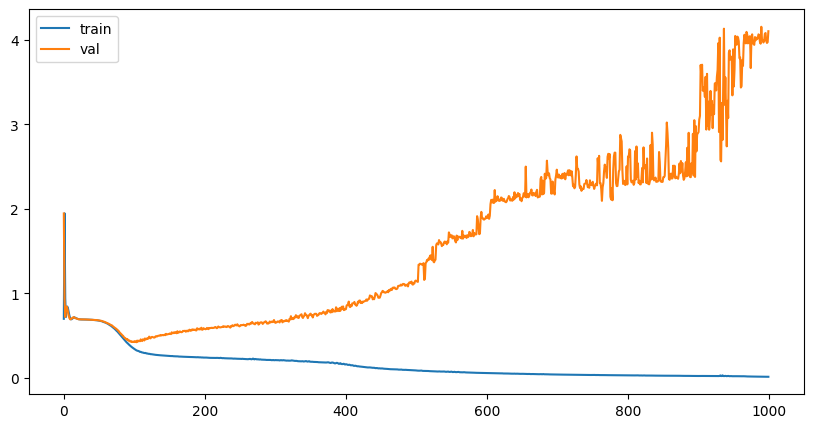

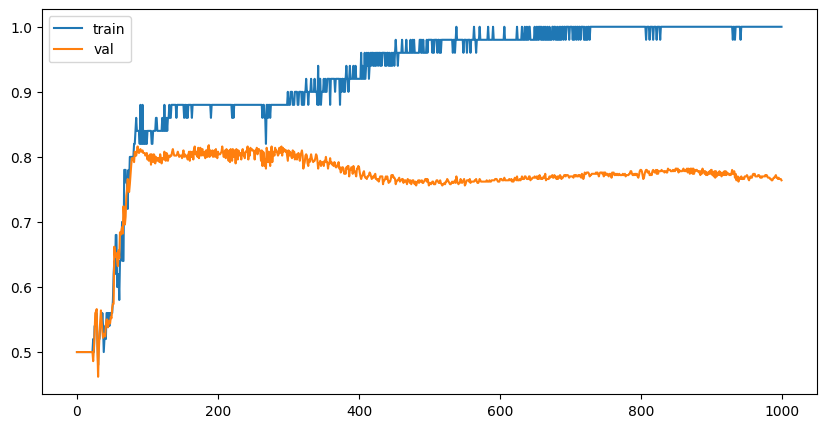

Test accuracy: 0.77


In [7]:


class FFN2(nn.Module):
    def __init__(self, input_size, output_size, init=nn.init.xavier_normal_):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 500)
        init(self.fc1.weight)
        self.fc2 = nn.Linear(500, 500)
        init(self.fc2.weight)
        self.fc3 = nn.Linear(500, output_size)
        init(self.fc3.weight)
        self.fc4 = nn.Sigmoid()

    def forward(self,x): 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        return x

def train(train_loader, val_loader, test_loader, device, epochs=1000):
    model = FFN2(2, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.BCELoss()  
    
    train_losses, train_accs, val_losses, val_accs, test_acc = [], [], [], [], 0

    for epoch in tqdm(range(epochs), desc="Epochs training"):
        model.train()  
        val_loss = 0
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            optimizer.step()
            output = model(data).squeeze()
            #output = output.reshape(target.shape)
            loss = criterion(output, target)
            loss.backward()
            train_loss += criterion(output, target)
            optimizer.step()
        train_losses.append(train_loss.detach().cpu()/len(train_loader))
        train_acc = success_rate(model, train_loader, device)
        train_accs.append(train_acc)
        
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            # output = output.reshape(target.shape)
            val_loss += criterion(output, target)
        val_losses.append(val_loss.detach().cpu()/len(val_loader))
        val_acc = success_rate(model, val_loader, device)
        val_accs.append(val_acc)
    
    test_acc = success_rate(model, test_loader, device)
        

    return train_losses, train_accs, val_losses, val_accs, test_acc
train_circle_dataset = CircleDataset(50, std=0.1, seed=None)
train_circle_loader = torch.utils.data.DataLoader(dataset=train_circle_dataset, batch_size=64, shuffle=True)

train_losses, train_accs, val_losses, val_accs, test_acc = train(train_circle_loader, circle_val_loader, circle_test_loader, device, epochs=1000)
print(val_accs, train_accs)
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.legend()
plt.show()

print(f"Test accuracy: {test_acc:.2f}")


## Influence of the amount of data
The most important regularization technique is more data. 
### Question 5
Create multiple train sets having [10, 100, 1000, 10000] datapoints and train the network on this train sets. Plot for each run the training and val losses and accuracy and the test accuracy. How does the overfitting evolves?

In [8]:
train_set_size = [10, 100, 1000, 10000]
train_losses = {}
val_losses = {}
train_accs = {}
val_accs = {}
test_accs = {}
for i in train_set_size:
    train_circle_dataset = CircleDataset(i, std=0.1, seed=None)
    train_circle_loader = torch.utils.data.DataLoader(dataset=train_circle_dataset, batch_size=64, shuffle=True)
    train_losses[i], train_accs[i], val_losses[i], val_accs[i], test_accs[i] = train(train_circle_loader, circle_val_loader, circle_test_loader, device, epochs=50)


Epochs training: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


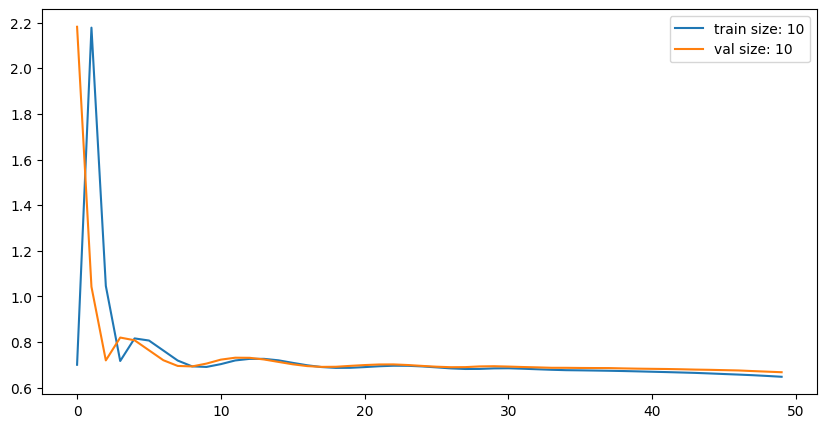

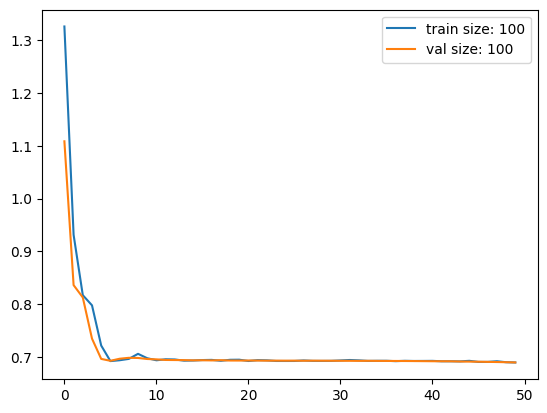

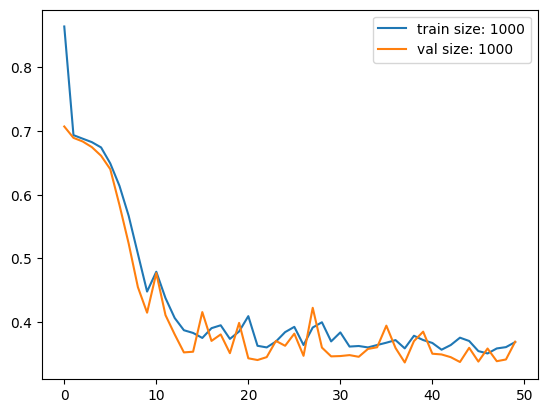

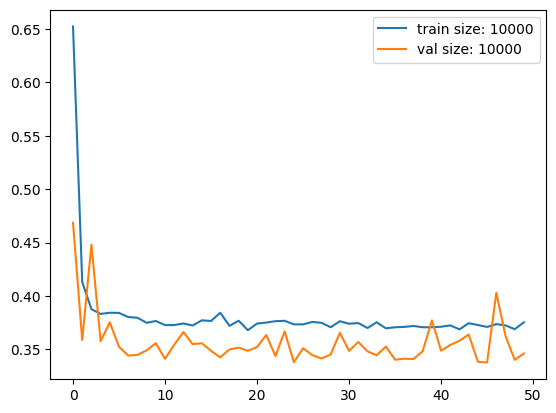

In [9]:
plt.figure(figsize=(10, 5))
for i in train_set_size:
    plt.plot(train_losses[i], label=f"train size: {i}")
    plt.plot(val_losses[i], label=f"val size: {i}")
    plt.legend()
    plt.show()


## Data augmentation

In real life, we often have to deal with a small dataset. In this case, we can use data augmentation to artificially increase the size of the dataset. For images multiple data augmentations techniques exist such as:
- Cropping
- Color Jittering
- Geometric transformations
- A lot other techniques (see `torchvision.Transforms` or `Albumentation`)

### Question 6
The main idea here is to "create" new data from existing datapoints.
Create a lambda transform that jitters the datapoints with Gaussian noise.
Use a dataset with 50 samples and train a classifier that leverage the augmentation with stds = [0, 1e-2, 1e-1, 2e-1, 1]. Make sure to have the same train dataset for each exp.
Discuss the results

Epochs training: 100%|██████████| 50/50 [00:05<00:00,  9.06it/s]


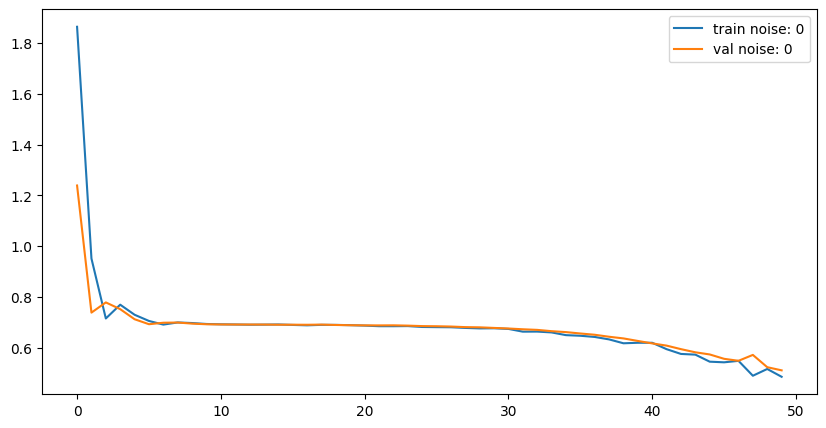

Epochs training: 100%|██████████| 50/50 [00:05<00:00,  9.09it/s]


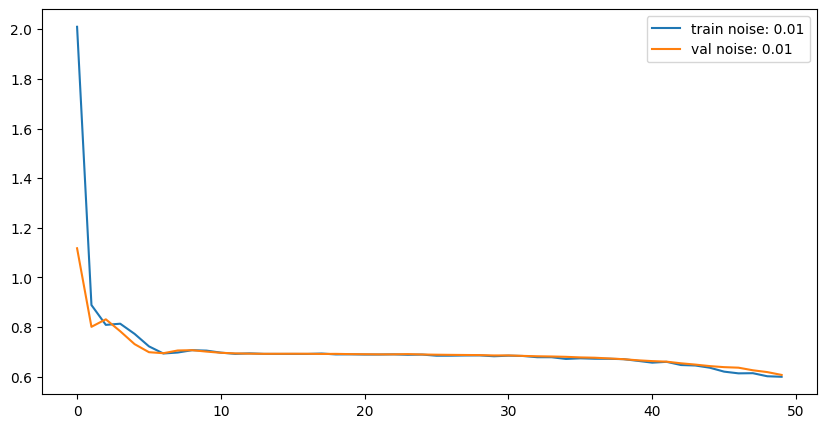

Epochs training: 100%|██████████| 50/50 [00:05<00:00,  9.11it/s]


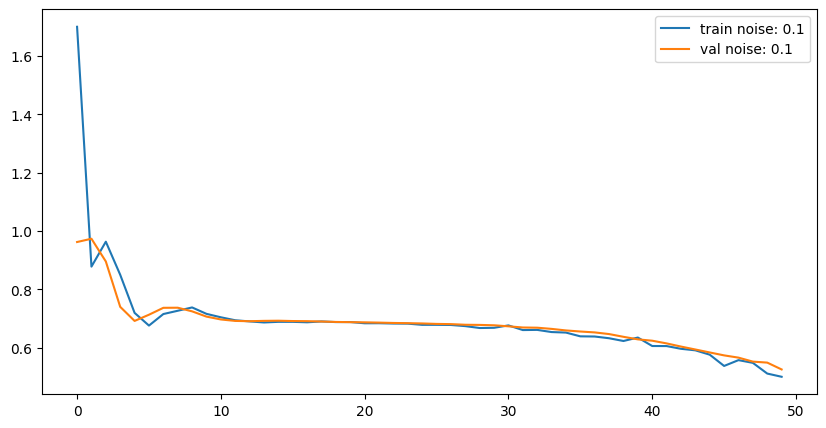

Epochs training: 100%|██████████| 50/50 [00:05<00:00,  9.12it/s]


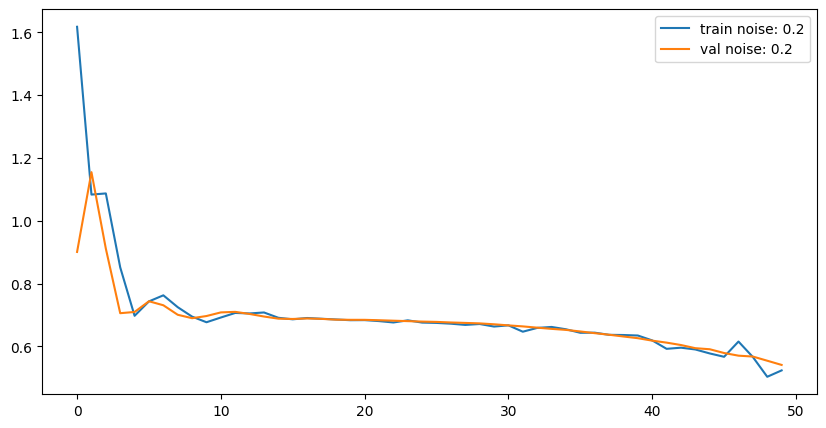

Epochs training: 100%|██████████| 50/50 [00:05<00:00,  9.14it/s]


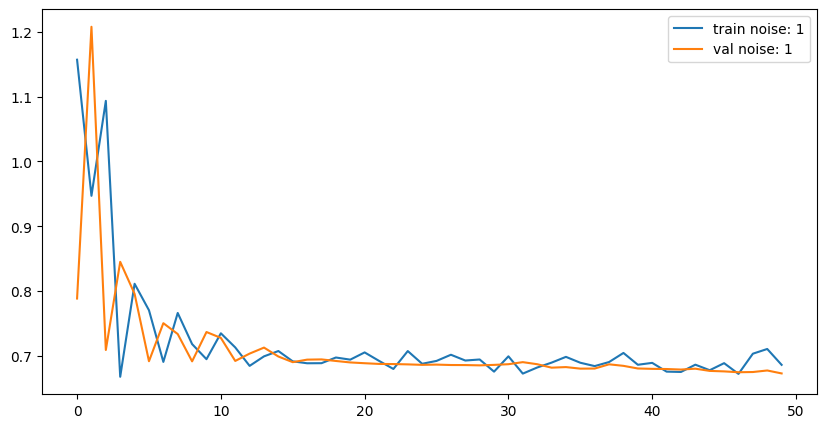

In [10]:
class RandomNoiseTransform(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

noise_levels = [0, 1e-2, 1e-1, 2e-1, 1]
num_noise_levels = len(noise_levels)
train_losses = {}
val_losses = {}
train_accs = {}
val_accs = {}
test_accs = {}

for i in noise_levels:
    train_circle_dataset1 = CircleDataset(50, std=0.1, seed=4047)
    train_circle_dataset2 = CircleDataset(50, std=0.1, seed=4047, transform=RandomNoiseTransform(std = i))
    
    train_circle_dataset = torch.utils.data.ConcatDataset([train_circle_dataset1, train_circle_dataset2])
    train_circle_loader = torch.utils.data.DataLoader(dataset=train_circle_dataset, batch_size=64, shuffle=True)
    train_losses[i], train_accs[i], val_losses[i], val_accs[i], test_accs[i] = train(train_circle_loader, circle_val_loader, circle_test_loader, device, epochs=50)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses[i], label="train noise: "+str(i))
    plt.plot(val_losses[i], label="val noise: "+str(i))
    plt.legend()
    plt.show()



### Question 7
Visualize the augmented training set for the noise level that gave the best test accuracy. Plot the original points in one color and the augmented one in another. To be able to visualize well what's happening, display 100 iterations on the augmented dataset. What conclusion can you draw from this observation. Could you think of a "smarter" way to augment the data if you can make assumption on the structure of the data manifold?

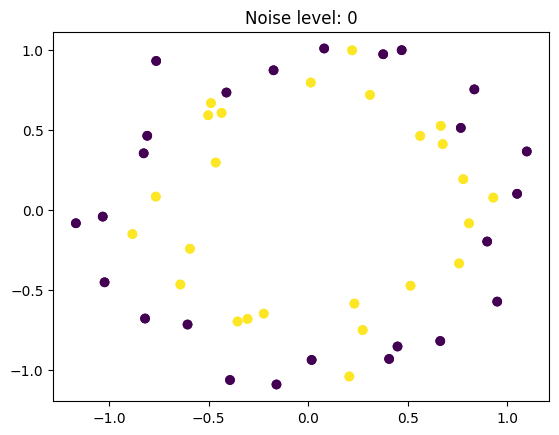

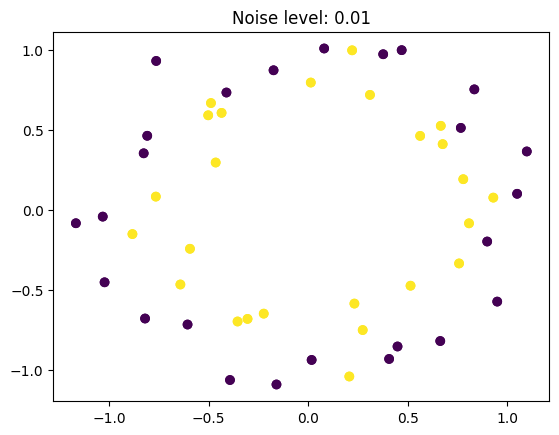

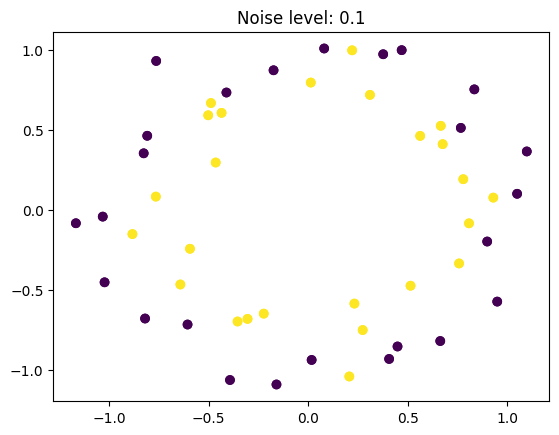

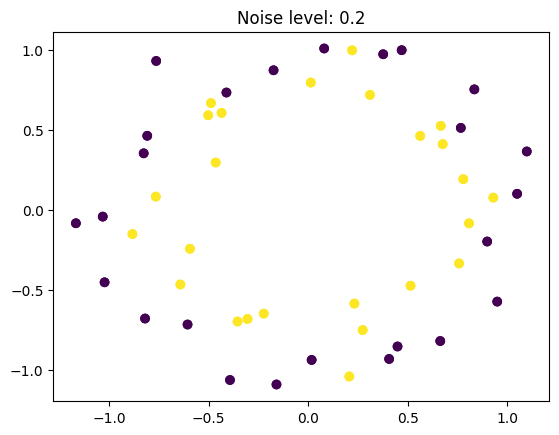

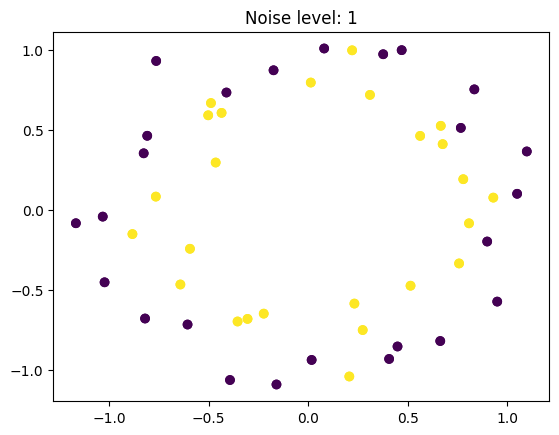

In [11]:
for i in noise_levels:
    train_circle_dataset1 = CircleDataset(50, std=0.1, seed=4047)
    train_circle_dataset2 = CircleDataset(50, std=0.1, seed=4047, transform=RandomNoiseTransform(std = i))
    plt.scatter(train_circle_dataset1.x[:,0], train_circle_dataset1.x[:,1], c=train_circle_dataset1.y)
    plt.scatter(train_circle_dataset2.x[:,0], train_circle_dataset2.x[:,1], c=train_circle_dataset2.y)
    plt.title("Noise level: "+str(i))
    plt.show()

### Question 8
Another way to regularize the training is to use dropout. Implement the dropout operation as an nn.Module. Remember, dropout is only implemented when training. Fortunally, `torch.nn.Module` has a flag `training` which is true if the model is training.

In [12]:
class Dropout(nn.Module):
      def __init__(self, p=0.5):
         super().__init__()
         self.p = p
         
      def forward(self, x):
         if self.training:
               mask = torch.bernoulli(torch.full_like(x, 1 - self.p))
               return x * mask
         return x

In [13]:
class FFNN(nn.Module):
      def __init__(self, input_size, output_size,dropout_rate=0, init=nn.init.xavier_normal_):
            super().__init__()
            self.fc1 = nn.Linear(input_size, 500)
            self.dropout = Dropout(dropout_rate)
            init(self.fc1.weight)
            self.fc2 = nn.Linear(500, 500)
            self.dropout2 = Dropout(dropout_rate)
            init(self.fc2.weight)
            self.fc3 = nn.Linear(500, output_size)
            init(self.fc3.weight)
            self.fc4 = nn.Sigmoid()
      def forward(self,x): 
            x = F.relu(self.fc1(x))
            x= self.dropout(x)
            x = F.relu(self.fc2(x))
            x= self.dropout2(x)
            x = self.fc3(x)
            x = self.fc4(x)
            return x

### Question 9
Use dropout to train a model on the circle dataset with 100 samples. Use the same architecture as in Question 8. train with different values of dropout and plot the training and validation loss and accuracy. Compute the test accuracy. What can you conclude?

In [14]:
def train_dropout(dropout_rate, train_loader, val_loader, test_loader, device, epochs=1000):
    model = FFNN(2, 1, dropout_rate= dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.BCELoss()  
    
    train_losses, train_accs, val_losses, val_accs, test_acc = [], [], [], [], 0

    for epoch in tqdm(range(epochs), desc="Epochs training"):
        model.train()  
        val_loss = 0
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data).squeeze()
            #output = output.reshape(target.shape)
            loss = criterion(output, target)
            loss.backward()
            train_loss += criterion(output, target)
            optimizer.step()
        train_losses.append(train_loss.detach().cpu()/len(train_loader))
        train_acc = success_rate(model, train_loader, device)
        train_accs.append(train_acc)
        
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            # output = output.reshape(target.shape)
            val_loss += criterion(output, target)
        val_losses.append(val_loss.detach().cpu()/len(val_loader))
        val_acc = success_rate(model, val_loader, device)
        val_accs.append(val_acc)
    
    test_acc = success_rate(model, test_loader, device)
        

    return train_losses, train_accs, val_losses, val_accs, test_acc

Epochs training: 100%|██████████| 50/50 [00:05<00:00,  9.99it/s]


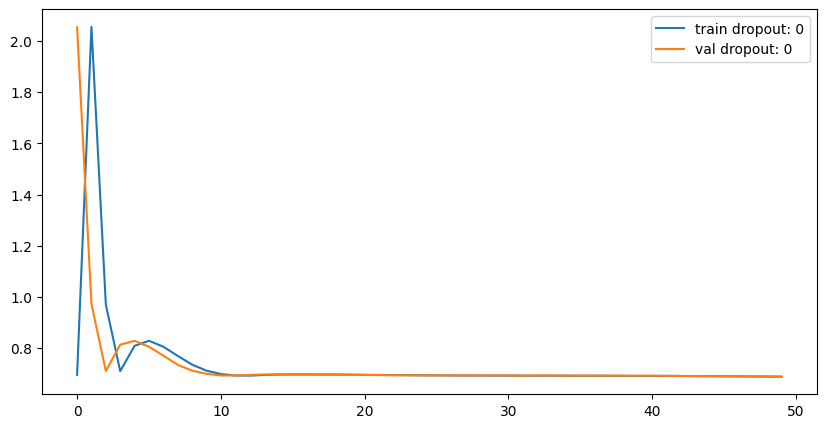

Epochs training: 100%|██████████| 50/50 [00:05<00:00, 10.00it/s]


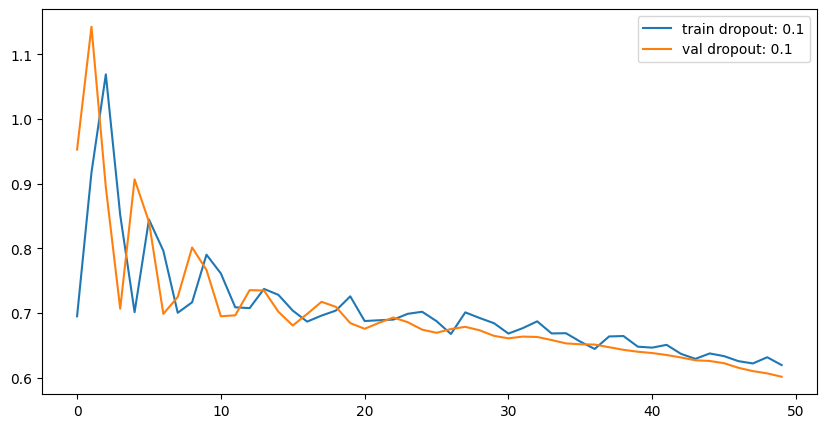

Epochs training: 100%|██████████| 50/50 [00:04<00:00, 10.03it/s]


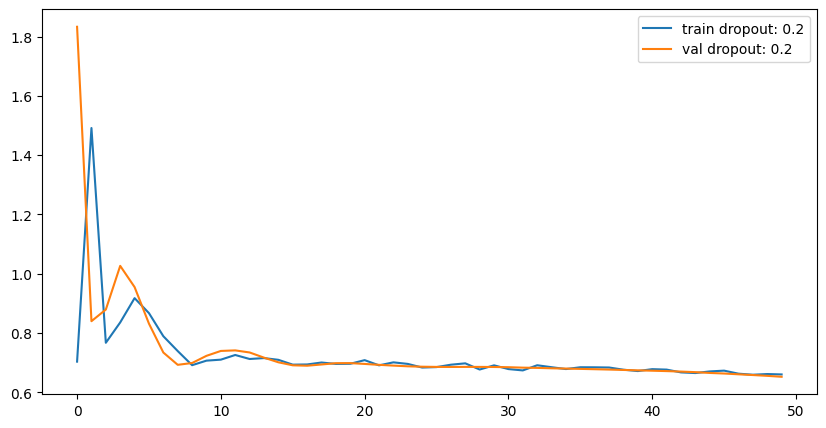

Epochs training: 100%|██████████| 50/50 [00:04<00:00, 10.04it/s]


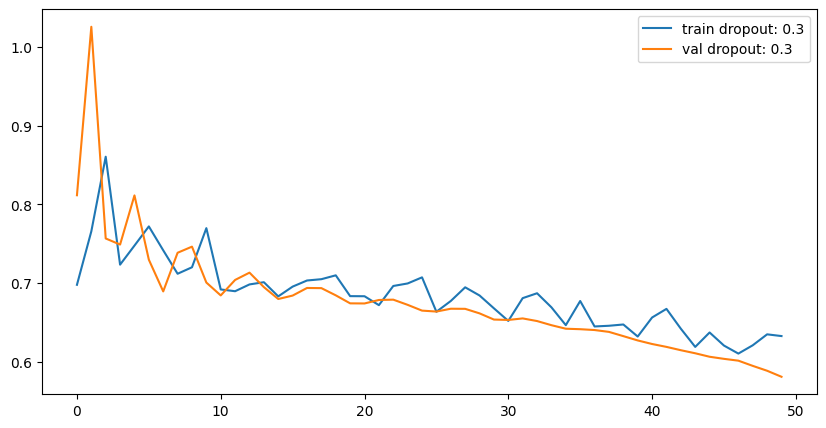

Epochs training: 100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


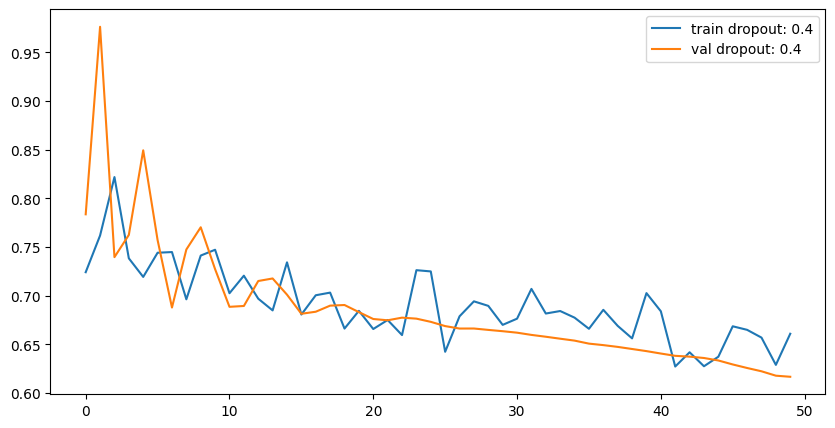

Epochs training: 100%|██████████| 50/50 [00:04<00:00, 10.03it/s]


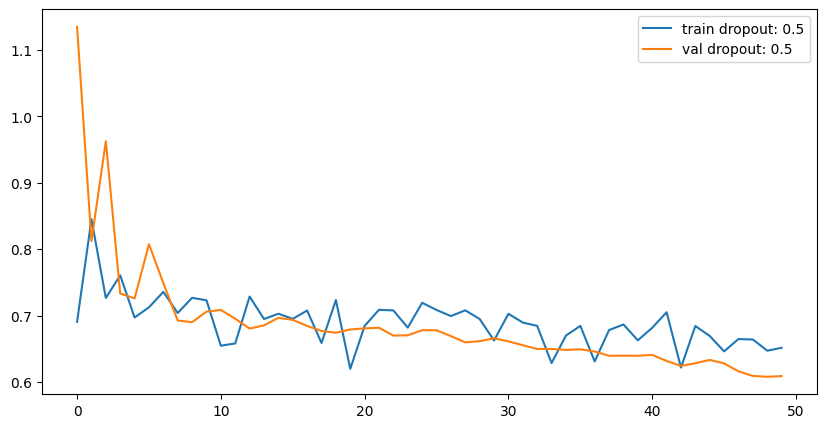

In [15]:
dropout_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

train_losses = {}
val_losses = {}
train_accs = {}
val_accs = {}
test_accs = {}
for i in dropout_rates:
    train_circle_dataset = CircleDataset(50, std=0.1, seed=None)
    train_circle_loader = torch.utils.data.DataLoader(dataset=train_circle_dataset, batch_size=64, shuffle=True)
    train_losses[i], train_accs[i], val_losses[i], val_accs[i], test_accs[i] = train_dropout(i, train_circle_loader, circle_val_loader, circle_test_loader, device, epochs=50)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses[i], label="train dropout: "+str(i))
    plt.plot(val_losses[i], label="val dropout: "+str(i))
    plt.legend()
    plt.show()


# ImageNet

The [ImageNet](http://www.image-net.org/) dataset is one of the main datasets used in image recognition. It contains more than 14 million images annotated according to the hierarchical structure of the [WordNet](https://wordnet.princeton.edu/) dataset.
Images are organized into classes and subclasses having semantic relationships, for example 'car' and 'plane' are 'vehicles', 'cat' and 'bird' are 'animals', 'plane' and 'bird' are 'flying objects', etc ...

ImageNet was accompanied by the challenge: 'Large Scale Visual Recognition Challenge' (ILSVRC), each edition offers different challenges (classification, detection, segmentation, ...) based on a subset of the dataset.

The advantage of having large datasets for learning is to be able to train networks on fairly general tasks, and after reuse the  learned weights for other applications. This operation is called transfer learning. A deep neural network (DNN) learns more and more abstract (hence high-level) features as one progresses through the layers.

Thus, a neural network (NN) pre-trained on a large dataset has low-level characteristics (learned in the first layers) potentially transferable to many tasks. These include texture, color, etc.  An immediate advantage is saving time as one does not have to re-train the NN for every new task from scratch. Another advantage is the fact that the models obtained are more robust. Indeed, a network pre-trained on a complete, large-scale dataset needs on the one hand fewer examples (since it has already seen a lot of them during the first training), and has less risk of over-learning the low level characteristics.

# AlexNet

In 2012, the [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) architecture won the ImageNet competition. The name comes from the first author Alex Krizhevsky. It is a CNN that classifies images into 1000 categories by producing a probability distribution over 1000 classes for each image. The metric used is the percentage of error among the *k* most probable classes (*top-k* error), i.e., we look to see if the true/correct prediction is among the *k* most probable classes predicted by the algorithm.
AlexNet got a top-5 error of 15.3% versus 26.2% for the second best result. This remarkable success led to the adoption of DNNs for the last decade.

Recall that a convolution takes as input a tensor of rank 3 whose first two axes are indexed according to the coordinates of the pixels ($W$, $H$ for width and height) and the last axis stores the channels (for RGB images this is 3). The convolutional kernel is a rank $4$ tensor whose first two axes are indexed according to the coordinates of the pixels supporting the kernel and the last two axes store a matrix of size $d_{in} \times d_{out}$ , where $d_{in}$ is the dimension of the features before convolution, and $d_{out}$ the dimension after the convolution, which will be applied to the input. 

The AlexNet architecture is illustrated in the following diagram:

![](https://drive.google.com/uc?export=view&id=1qXGfYOJRU0pgCcGydat0u2Y9csso9nIQ)

Images are represented by volumes whose height and width are the dimensions of the image and the depth is the number of channels. The size of the convolutional kernel is indicated by the small squares. For instance, we see that the input image is an RGB image of size 224 by 224 and that the first filter has a size of 11 by 11, its input dimension is 3 and its output dimension is 64.

### Question 10: 
Implement the AlexNet architecture. 
You will complete the following code:

In [29]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            
		)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


Note that some information does not appear on the diagram: 
* the activations are ReLu
* every convolution or fully connected layer is followed by an activation. 

Recall the convolution and pooling operations: for an image of size *h* with a filter of size *k*, padding of *p* and stride of *s* the output size is:

$$ \frac{h-k+2p}{s} + 1 $$

In AlexNet the convolutional layers have a stride of 1 (except the 1st) and the pooling layers have a 'kernel' of size 3 and stride 2. 

Finally, recall the adaptive average pooling function (that performs adaptive pooling), which renders an "image" of predefined size (here 6 by 6). You need to deduce the missing parameters to implement the network described in the diagram above.

# Transfer Learning 

Note that the above AlexNet architecture has two distinct parts:  
* a first "features" sub-network, responsible for extracting relevant characteristics from the image, and
* a "classifier" that is applied on top (i.e., the fully connected layers) 

The "features" part is reusable for *other* tasks. We will import a pre-trained model on ImageNet for the AlexNet architecture. We will then use the corresponding "features" for another classification problem.

We will use the following script defining a "classifier" and applying it to AlexNet features, pre-trained or not.

In [2]:
model_urls = {
'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def alexnet_classifier(num_classes, input_features):
    classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(input_features, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, num_classes),
    )
    return classifier


def alexnet(num_classes, pretrained=False, **kwargs):
    """AlexNet model architecture from the "One weird trick..." 
    <https://arxiv.org/abs/1404.5997> paper.
    
    Args:
    pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = models.alexnet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
        for p in model.features.parameters():
            p.requires_grad = False
    
    # Example dummy input to calculate feature size dynamically
    dummy_input = torch.randn(1, 3, 224, 224)  # Adjust the size if your input image size is different
    with torch.no_grad():
        dummy_features = model.features(dummy_input)
    input_features = dummy_features.view(-1).shape[0]

    # Now, create the classifier with the correct input size
    classifier = alexnet_classifier(num_classes, input_features)
    model.classifier = classifier

    return model

We will compare the pre-trained model to a non-pretrained model on the CIFAR-10 dataset. This is a much smaller dataset than ImageNet but still very useful for evaluating models while avoiding long training times. It contains 60,000 images (50,000 training, 10,000 test) of size 32 by 32 split into 10 classes. Note that gradient descent has been disabled for pre-trained feature weights to avoid corrupting them during training.

We will load the dataset with the following script:

Files already downloaded and verified
Files already downloaded and verified


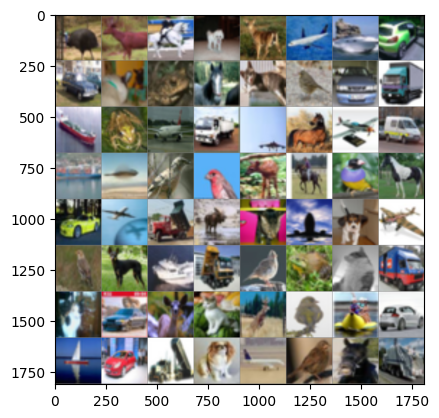

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
     

batch_size = 64

idx_train = np.arange(50000)
np.random.shuffle(idx_train)
idx_train = idx_train[:1000]

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2,
                                         sampler=SubsetRandomSampler(idx_train))

idx_test = np.arange(10000)
np.random.shuffle(idx_test)
idx_test = idx_test[:1000]

testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

You will be able to display the filters of the first convolutional layer, and compare these filters for the pre-trained network and the one trained on CIFAR-10, by viewing them with the following script:

In [4]:
def imshow_filters(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_weights(MyModel):
  """Displays the filters of the 1st convolutional layer
  of the input model 
  Input:
  - MyModel: the input model
  """
  ii = 0
  filter = MyModel.features[ii].weight.cpu().data
  #Normalizing the values to [0,1]
  f_min, f_max = filter.min(), filter.max()
  filter = (filter - f_min) / (f_max - f_min)
  print("The filter shape is {}".format(filter.shape))
  imshow_filters(torchvision.utils.make_grid(filter))


We have intentionally reduced the size of the images to speed up training. Note that AlexNet being is designed for images of size 224 by 224, we apply a scaling transformation (by the bilinear interpolation method, seen in TD2).

In the following, we will use the following training loop:

In [5]:
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  
  return 100.0 * correct

In [6]:
def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True):
  loss_train = []
  loss_test = []
  total = 0
  for epoch in range(n_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):

          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          
          # zero the parameter gradients
          optimizer.zero_grad()

          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)

          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
      
  print('Finished Training')

### Question 11
Run the following code and compare the performance between (i) the model and (ii) its pre-trained version. Specifically, compare the filters of the first convolutional layers.

using cuda


/Data/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


[1,    10] loss: 0.034
[1,    10] acc: 0.091
[2,    10] loss: 0.034
[2,    10] acc: 0.101
[3,    10] loss: 0.034
[3,    10] acc: 0.121
[4,    10] loss: 0.033
[4,    10] acc: 0.132
[5,    10] loss: 0.033
[5,    10] acc: 0.195
[6,    10] loss: 0.033
[6,    10] acc: 0.189
[7,    10] loss: 0.031
[7,    10] acc: 0.184
[8,    10] loss: 0.030
[8,    10] acc: 0.238
[9,    10] loss: 0.030
[9,    10] acc: 0.242
[10,    10] loss: 0.031
[10,    10] acc: 0.229
[11,    10] loss: 0.028
[11,    10] acc: 0.282
[12,    10] loss: 0.028
[12,    10] acc: 0.248
[13,    10] loss: 0.027
[13,    10] acc: 0.279
[14,    10] loss: 0.027
[14,    10] acc: 0.263
[15,    10] loss: 0.027
[15,    10] acc: 0.285
[16,    10] loss: 0.025
[16,    10] acc: 0.313
[17,    10] loss: 0.025
[17,    10] acc: 0.312
[18,    10] loss: 0.023
[18,    10] acc: 0.393
[19,    10] loss: 0.023
[19,    10] acc: 0.378
[20,    10] loss: 0.023
[20,    10] acc: 0.380
[21,    10] loss: 0.023
[21,    10] acc: 0.339
[22,    10] loss: 0.023
[22,   

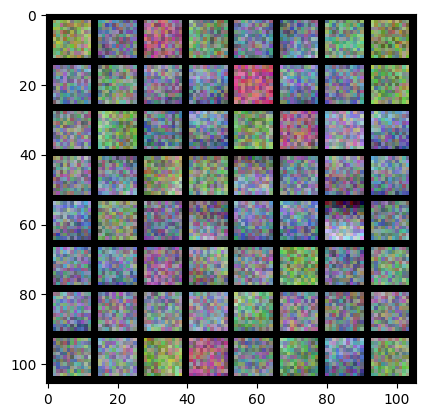

Accuracy of the network on the test images: 37 %


1858900.0

In [7]:
# This is the main part where you run the training and test loops and compute accuracy
net = alexnet(num_classes=10, pretrained=False)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

# VGG-Net

The VGG-Net architecture developed by the Visual Geometry Group team at the University of Oxford won second place in the ImageNet 2014 challenge. The variants of VGG-Net obtains up to 7.3% top-5 error on the ImageNet 2012 challenge vs 15.3% for AlexNet.

The VGG-Net architecture is available in several variants presented in the following table:

![](https://drive.google.com/uc?export=view&id=1JB2rzZHiePoKlwqqeeHg-yTwIvMjw4-m)

In VGG-Net: 
* All the convolutions use a kernel of size 3 by 3 with a padding of 1. The convolutions therefore *preserve* the size of the image.
* All the max pooling layers have a size of 2 by 2 and a stride of 2. 
* An adaptive avg pooling layer is applied before classifying it so as to reduce the image to a size 7 by 7. This is then vectorized, then sent to the classifier.

Note that the "features" part of VGG-Net can be stored in a list with a simple loop going through a list of parameters (here `cfg ['A']`). 

### Question 12

You need to complete the `make_layers` function with the following code. 
Note, if `batch_norm == True` we will need to add a batch norm layer between each convolutional layer and the following ReLu layer.

In [10]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth' # bn: batch normalization
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = { # M stands for max pooling 
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

### Question 13
As you did with AlexNet, evaluate (using the following functions) version A of VGG-Net (i) with and (ii) without pre-training on ImageNet. 
Use `n_epoch = 15`. 

Bonus: do the same for version E. 

In [11]:
def vgg_11_classifier(num_classes):
  classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
  return classifier
  
def vgg11_bn(num_classes, pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs) # change cfg version for bonus
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn'])) # change model url for bn
    model.classifier = vgg_11_classifier(num_classes)
    return model

using cuda
[1,    10] loss: 0.039
[1,    10] acc: 0.072
[2,    10] loss: 0.034
[2,    10] acc: 0.106
[3,    10] loss: 0.034
[3,    10] acc: 0.103
[4,    10] loss: 0.034
[4,    10] acc: 0.096
[5,    10] loss: 0.034
[5,    10] acc: 0.088
[6,    10] loss: 0.034
[6,    10] acc: 0.115
[7,    10] loss: 0.035
[7,    10] acc: 0.104
[8,    10] loss: 0.034
[8,    10] acc: 0.082
[9,    10] loss: 0.034
[9,    10] acc: 0.104
[10,    10] loss: 0.034
[10,    10] acc: 0.093
[11,    10] loss: 0.034
[11,    10] acc: 0.081
[12,    10] loss: 0.034
[12,    10] acc: 0.099
[13,    10] loss: 0.034
[13,    10] acc: 0.076
[14,    10] loss: 0.034
[14,    10] acc: 0.099
[15,    10] loss: 0.034
[15,    10] acc: 0.114
Finished Training
The filter shape is torch.Size([64, 3, 3, 3])


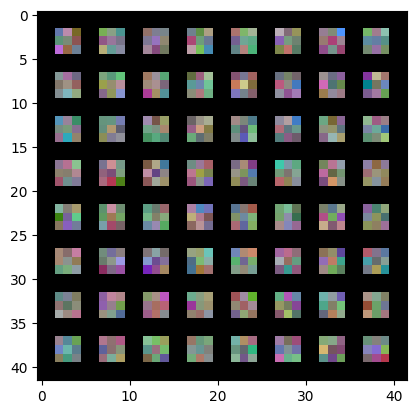

Accuracy of the network on the test images: 10 %


500000.0

In [16]:
# (i) Without pre-training
net = vgg11_bn(num_classes=10, pretrained=False)
net = VGG(make_layers(cfg['A']), num_classes=10)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 15,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /users/eleves-b/2021/ossama.faraji/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:06<00:00, 87.3MB/s] 


using cuda
[1,    10] loss: 0.031
[1,    10] acc: 0.254
[2,    10] loss: 0.020
[2,    10] acc: 0.417
[3,    10] loss: 0.016
[3,    10] acc: 0.501
[4,    10] loss: 0.012
[4,    10] acc: 0.628
[5,    10] loss: 0.009
[5,    10] acc: 0.709
[6,    10] loss: 0.007
[6,    10] acc: 0.733
[7,    10] loss: 0.006
[7,    10] acc: 0.755
[8,    10] loss: 0.003
[8,    10] acc: 0.814
[9,    10] loss: 0.004
[9,    10] acc: 0.788
[10,    10] loss: 0.004
[10,    10] acc: 0.803
[11,    10] loss: 0.002
[11,    10] acc: 0.836
[12,    10] loss: 0.003
[12,    10] acc: 0.821
[13,    10] loss: 0.002
[13,    10] acc: 0.835
[14,    10] loss: 0.001
[14,    10] acc: 0.846
[15,    10] loss: 0.003
[15,    10] acc: 0.831
Finished Training
The filter shape is torch.Size([64, 3, 3, 3])


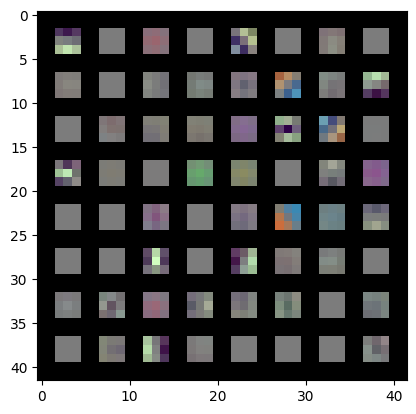

Accuracy of the network on the test images: 54 %


2743400.0

In [17]:

# (ii) With pre-training
pretrained_net = net = vgg11_bn(num_classes=10, pretrained=True)
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(pretrained_net, optimizer, trainloader, testloader, criterion,  n_epoch = 15,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)


# InceptionNet (Bonus)

The [InceptionNet](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/43022.pdf) architecture developed at Google won the ImageNet 2014 challenge with a top-5 error of 6.7%. A problem that appears in the design of a CNN architecture is the choice of the size of the convolutional kernels. More generally, in image processing, the question of which scale to detect patterns always arises. The InceptionNet architecture addresses this problem by relying on the notion of block inception. This is a multi-scale block allowing the network to choose between different scales / resolutions / pooling.

You need complete the Inception class implementing the block:

![](https://drive.google.com/uc?export=view&id=1RrZuOTGXU9VE9L9eRjiMCqwAW3gl57zB)

described in the GoogLeNet article (Figure 2b).

The following code implements a truncated version of GoogLeNet:

In [23]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=3):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.pre_layers(x)

        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


### Question 20 (Bonus) 

Test your GoogLeNet implementation on the FashionMNIST dataset:

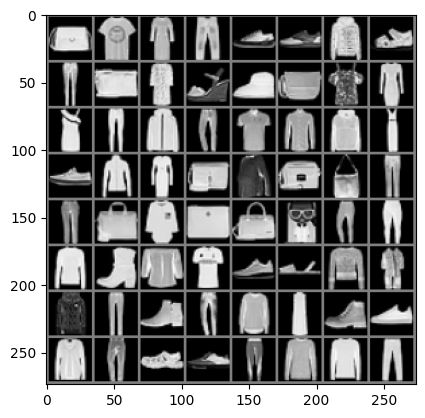

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

transform = transforms.Compose(
    [transforms.Resize(size=(32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
     
batch_size = 64

trainset = torchvision.datasets.FashionMNIST("./data",download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

testset = torchvision.datasets.FashionMNIST("./data",download=True,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [29]:
def show_weights(model, num_columns=6):
    """Displays the filters of the 1st convolutional layer of the input model in a grid."""
    conv1 = model.pre_layers[0].weight.data.cpu()
    vmin, vmax = conv1.min(), conv1.max()
    conv1 = (conv1 - vmin) / (vmax - vmin)
    num_filters = conv1.shape[0]
    num_rows = (num_filters + num_columns - 1) // num_columns
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(2*num_columns, 2*num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(conv1[i][0], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

using cuda


[1,    10] loss: 0.019
[1,    10] acc: 0.544
[1,    20] loss: 0.013
[1,    20] acc: 0.649
[1,    30] loss: 0.011
[1,    30] acc: 0.677
[1,    40] loss: 0.011
[1,    40] acc: 0.660
[1,    50] loss: 0.010
[1,    50] acc: 0.668
[1,    60] loss: 0.008
[1,    60] acc: 0.725
[1,    70] loss: 0.008
[1,    70] acc: 0.710
[1,    80] loss: 0.007
[1,    80] acc: 0.742
[1,    90] loss: 0.007
[1,    90] acc: 0.743
[1,   100] loss: 0.008
[1,   100] acc: 0.693
[1,   110] loss: 0.006
[1,   110] acc: 0.742
[1,   120] loss: 0.006
[1,   120] acc: 0.746
[1,   130] loss: 0.007
[1,   130] acc: 0.736
[1,   140] loss: 0.008
[1,   140] acc: 0.693
[1,   150] loss: 0.008
[1,   150] acc: 0.705
[1,   160] loss: 0.007
[1,   160] acc: 0.734
[1,   170] loss: 0.007
[1,   170] acc: 0.717
[1,   180] loss: 0.007
[1,   180] acc: 0.726
[1,   190] loss: 0.006
[1,   190] acc: 0.770
[1,   200] loss: 0.007
[1,   200] acc: 0.730
[1,   210] loss: 0.005
[1,   210] acc: 0.762
[1,   220] loss: 0.006
[1,   220] acc: 0.747
[1,   230]

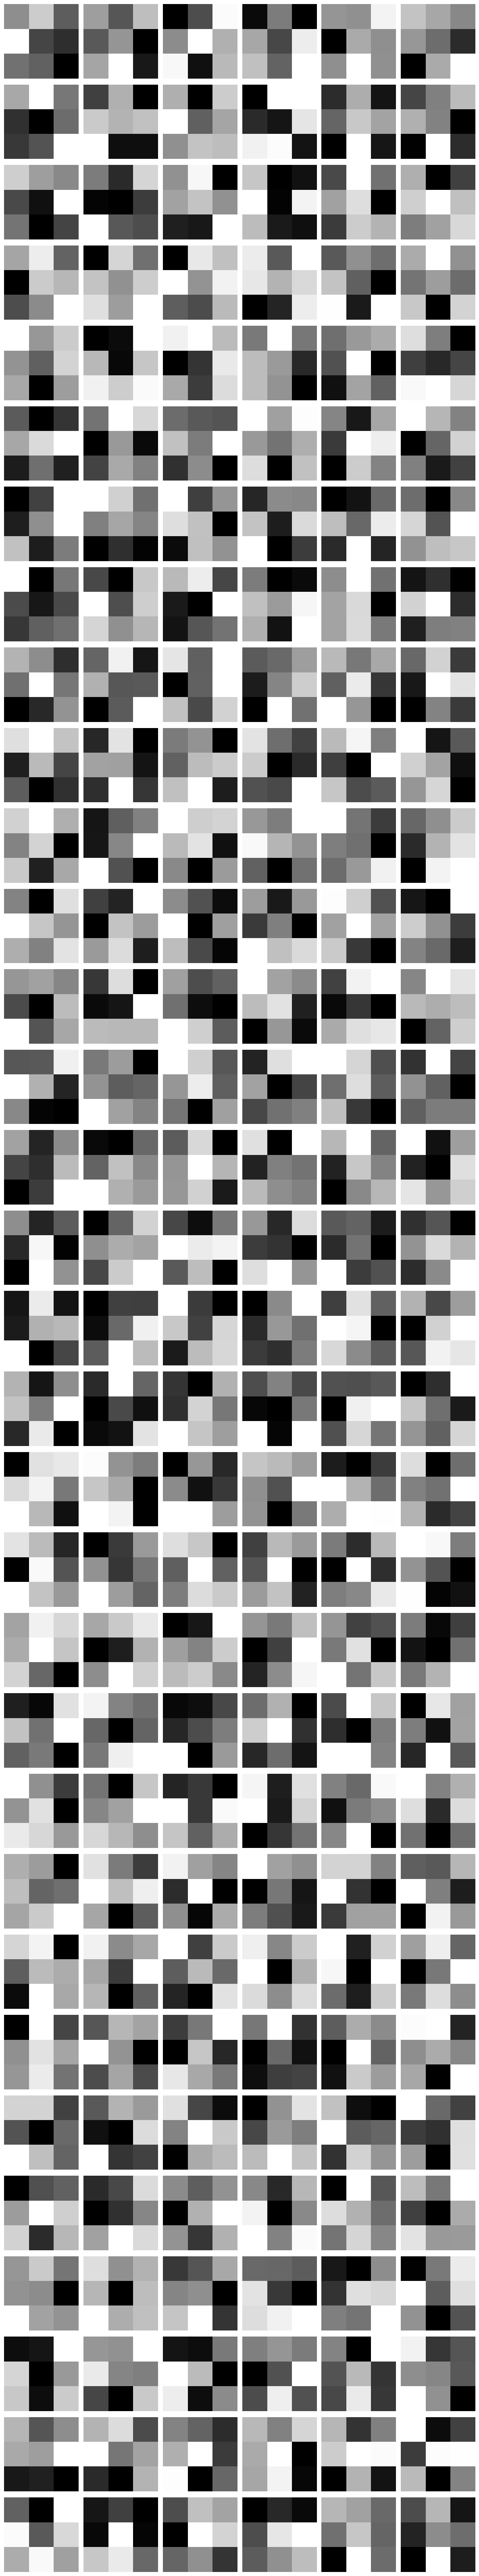

Accuracy of the network on the test images: 91 %


919900.0

In [30]:
net = GoogLeNet(input_dim=1)
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 15,
      train_acc_period = 10,
      test_acc_period = 1000)
show_weights(net)
accuracy(net, testloader, cuda=use_cuda)

## Colab Cheatsheet 

*   show keyboard shortcuts, Ctrl/Cmd M H, H 
*   Insert code cell above, Ctrl/Cmd M A, A
*   Insert code cell below, Ctrl/Cmd M B, B
*   Delete cell/selection, Ctrl/Cmd M D, DD
*   Interrupt execution, Ctrl/Cmd M I, II
*   Convert to code cell, Ctrl/Cmd M Y, Y
*   Convert to text cell, Ctrl/Cmd M M, M
*   Split at cursor, Ctrl/Cmd M -, Ctrl Shift -
